In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, LeakyReLU, ReLU, LayerNormalization, GaussianNoise
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D
from keras import initializers
from math import ceil
import time
from tensorflow_addons.layers import SpectralNormalization

In [2]:
#Updated Versions
#Spectral Normalization Model
def build_cifar10_discriminator(image_shape=(32, 32, 3)):
    
    model = Sequential()
    
    #16 output filters, so number of channels jumps from 1 to 16
    #kernel_size = 5 means we use a 5x5 convolution window
    #strides defaults to (1,1) when unspecified, "same" padding means we'll preserve the image size
    model.add(Conv2D(16, kernel_size=5, strides=2, padding="same", input_shape=(32, 32, 3), 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))) #40
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(32, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    
    #Second layer
    model.add(SpectralNormalization(Conv2D(64, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(128, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))

    #Flatten for Final Output Layer
    model.add(Flatten())

    #Output layer
    model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Activation("sigmoid"))
    
    #Final Output
    print("\nDiscriminator")
    model.summary()
    return model




#Spectral Normalization Model
def build_cifar10_generator(z_dim=100):
    
    model = Sequential()
    
    #First Layer (4x4)
    model.add(Dense(4*4*128, input_dim=z_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Reshape((4,4,128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 8x8
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
          use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    
    # output layer
    model.add(Activation('tanh'))

    print("\nGenerator")
    model.summary()
    return model




#Build and Compile Networks
#Variables
#Loss Functions:  Don't seem to matter for performance, any choice will work
#Learning rates:  Trying higher learning rate for Discriminator;  
#Discriminator is easier to succeed, gives generator a better chance at competition, prevents mode collapse
lr_d=2e-4
lr_g=1e-4
z_dim=100
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
image_shape = X_train[0].shape

D = build_cifar10_discriminator(image_shape)
G = build_cifar10_generator(z_dim)

D.compile(Adam(learning_rate=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
D.trainable = False

z = Input(shape=(z_dim, ))
D_of_G = Model(inputs=z, outputs=D(G(z)))
D_of_G.compile(Adam(learning_rate=lr_g, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])


Discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 spectral_normalization (Spe  (None, 8, 8, 32)         12864     
 ctralNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 spectral_normalization_1 (S  (None, 4, 4, 64)         51328     
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4,

In [3]:
#Function for plotting images
def plot_images(images, filename):
    h, w, c = images.shape[1:]
    #images = (1/(2*2.25)) * images + 0.5
    images = 0.5 * images + 0.5
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    
#Function for Plotting Losses During Training
def plot_losses(losses_d, losses_g, filename):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    #plt.close()
    
#Functions for smoothing labels of 1 and 0
# Smoothing class=1 to [0.8, 1.0]
def smooth_positive_labels(y):
    return y - 0.2 + (np.random.random(y.shape) * 0.2)

# Smoothing class=0 to [0.0, 0.1]
def smooth_negative_labels(y):
    return y + (np.random.random(y.shape) * 0.1)

#Function for generating latent points to feed into generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
     x_input = np.random.randn(latent_dim * n_samples)
     # reshape into a batch of inputs for the network
     x_input = x_input.reshape((n_samples, latent_dim))
     return x_input
    

#Function for adding noise to images
#  Adding noise to images prevents discriminator overfitting, inhibits performance to allow
#   for better rivalry with the generator (which is generally slower to train)
#This function adds 'salt and pepper noise' (randomly set pixels to either -1 or 1) 
# def noisy(image):
#     row,col,ch = image.shape
#     s_vs_p = 0.5
#     amount = 0.004
#     out = np.copy(image)
#     # Salt mode
#     num_salt = np.ceil(amount * image.size * s_vs_p)
#     coords = tuple([np.random.randint(0, i - 1, int(num_salt))
#             for i in image.shape])
#     out[coords] = 1

#     # Pepper mode
#     num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
#     coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
#             for i in image.shape])
#     out[coords] = -1
#     return out

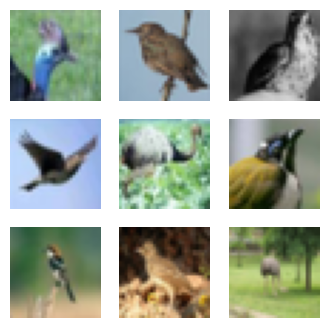

In [17]:
# #Test only grabbing images of one type

#Load the CIFAR10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#Concatenate X_train and X_test for more data
X_train = np.concatenate((X_train,X_test))
y_train = np.concatenate((y_train,y_test))
#Only use index 2 AKA birds
index = np.where(y_train.reshape(-1) == 2)
X_train = X_train[index]
y_train = y_train[index]

#Testing to make sure it's just airplanes
fig,axs = plt.subplots(3,3,figsize=(4,4),sharey=True,sharex=True)
cnt=0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X_train[-9:][cnt,:,:])
        axs[i, j].axis('off')
        cnt+=1

image shape (32, 32, 3), min val -0.9450980424880981, max val 0.9529411792755127
Epoch 0
Time for epoch:  25.531012773513794
loss_d=0.35522, loss_g=1.90465
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

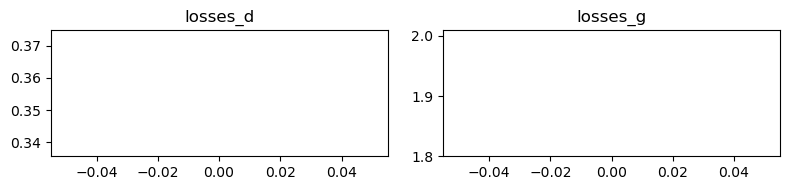

Epoch 1
Time for epoch:  23.50035524368286
Epoch 2
Time for epoch:  23.564433574676514
Epoch 3
Time for epoch:  23.49266028404236
Epoch 4
Time for epoch:  23.72970414161682
Epoch 5
Time for epoch:  23.254380226135254
loss_d=0.56158, loss_g=1.09464
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


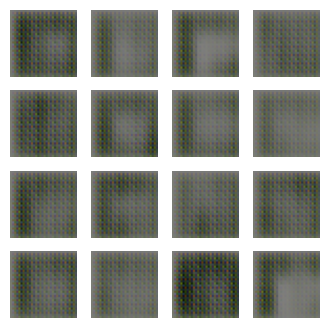

<Figure size 1600x1600 with 0 Axes>

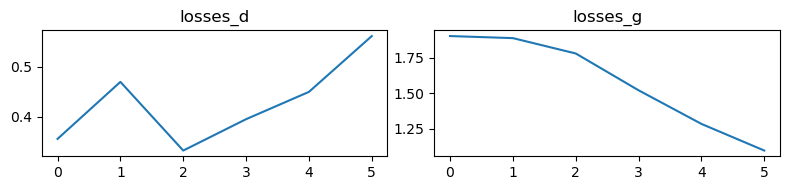

Epoch 6
Time for epoch:  23.95195484161377
Epoch 7
Time for epoch:  23.58077049255371
Epoch 8
Time for epoch:  23.26305890083313
Epoch 9
Time for epoch:  24.145846128463745
Epoch 10
Time for epoch:  23.284245252609253
loss_d=0.54843, loss_g=0.99745
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


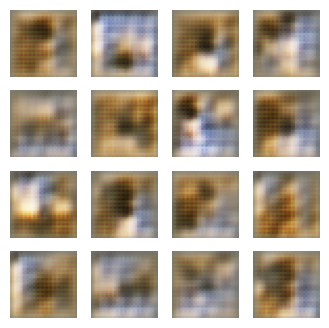

<Figure size 1600x1600 with 0 Axes>

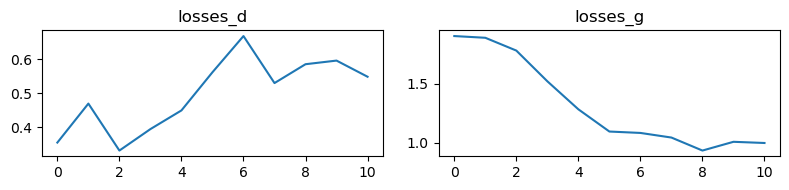

Epoch 11
Time for epoch:  23.850662231445312
Epoch 12
Time for epoch:  23.47198176383972
Epoch 13
Time for epoch:  25.212214708328247
Epoch 14
Time for epoch:  23.33815312385559
Epoch 15
Time for epoch:  23.23071789741516
loss_d=0.63787, loss_g=1.06223
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


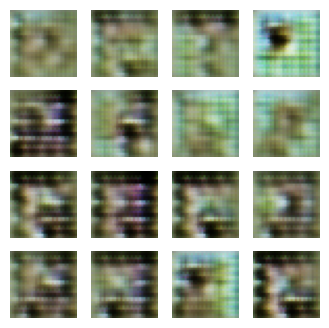

<Figure size 1600x1600 with 0 Axes>

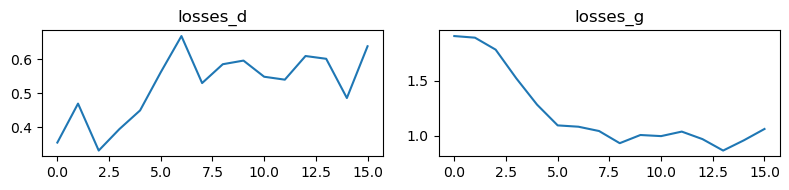

Epoch 16
Time for epoch:  23.204352855682373
Epoch 17
Time for epoch:  23.06805920600891
Epoch 18
Time for epoch:  23.32781147956848
Epoch 19
Time for epoch:  23.75409197807312
Epoch 20
Time for epoch:  23.176559448242188
loss_d=0.58357, loss_g=1.07230
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


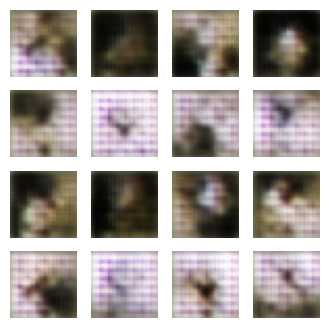

<Figure size 1600x1600 with 0 Axes>

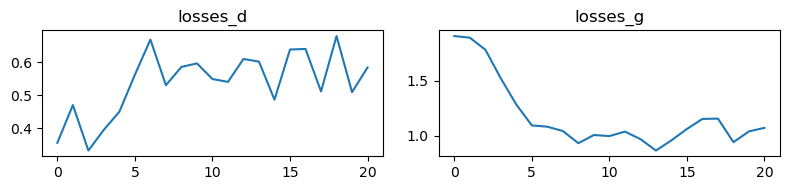

Epoch 21
Time for epoch:  23.20641255378723
Epoch 22
Time for epoch:  23.16636633872986
Epoch 23
Time for epoch:  24.19997239112854
Epoch 24
Time for epoch:  24.165757179260254
Epoch 25
Time for epoch:  24.063048839569092
loss_d=0.65877, loss_g=0.92077
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


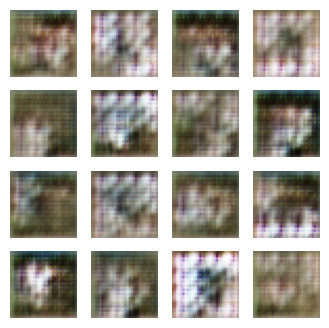

<Figure size 1600x1600 with 0 Axes>

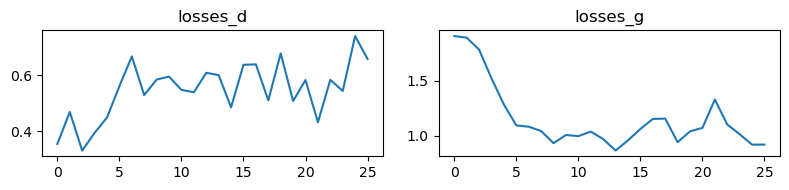

Epoch 26
Time for epoch:  24.2093608379364
Epoch 27
Time for epoch:  22.813414096832275
Epoch 28
Time for epoch:  22.584876775741577
Epoch 29
Time for epoch:  22.508713722229004
Epoch 30
Time for epoch:  22.874342679977417
loss_d=0.65228, loss_g=0.97800
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


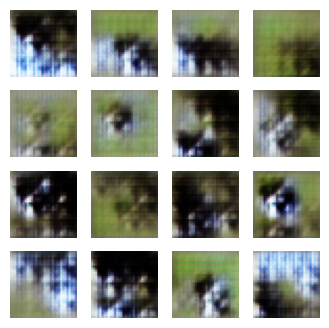

<Figure size 1600x1600 with 0 Axes>

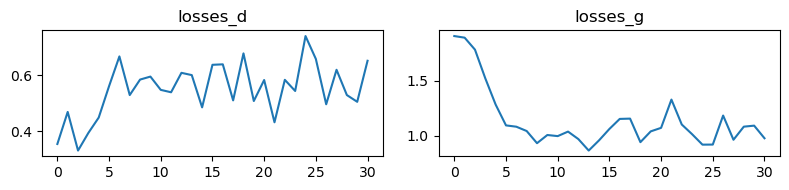

Epoch 31
Time for epoch:  22.674263954162598
Epoch 32
Time for epoch:  22.86162567138672
Epoch 33
Time for epoch:  24.40192413330078
Epoch 34
Time for epoch:  22.890236377716064
Epoch 35
Time for epoch:  22.67963743209839
loss_d=0.53771, loss_g=1.25694
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


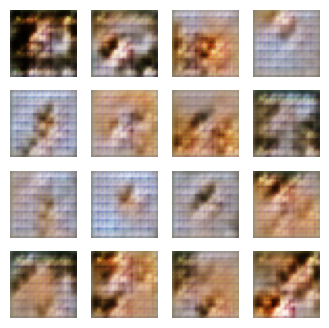

<Figure size 1600x1600 with 0 Axes>

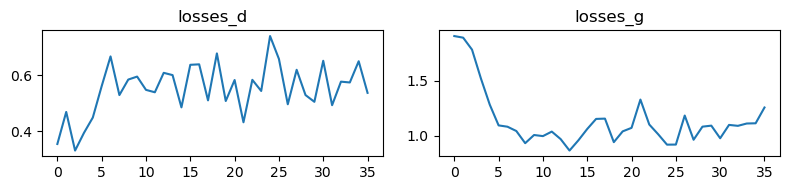

Epoch 36
Time for epoch:  22.928609132766724
Epoch 37
Time for epoch:  22.727420330047607
Epoch 38
Time for epoch:  22.872260570526123
Epoch 39
Time for epoch:  24.401073694229126
Epoch 40
Time for epoch:  22.741764545440674
loss_d=0.56728, loss_g=1.22659
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


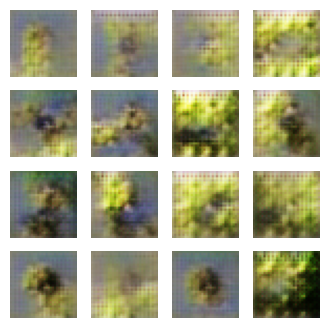

<Figure size 1600x1600 with 0 Axes>

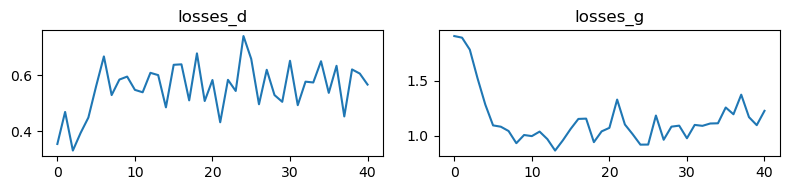

Epoch 41
Time for epoch:  22.68314027786255
Epoch 42
Time for epoch:  24.306126594543457
Epoch 43
Time for epoch:  23.57283043861389
Epoch 44
Time for epoch:  24.06023621559143
Epoch 45
Time for epoch:  23.95472002029419
loss_d=0.63408, loss_g=1.38963
2/2 [==============================] - 0s 3ms/step
	Plotting images and losses


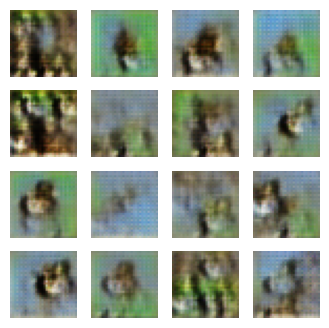

<Figure size 1600x1600 with 0 Axes>

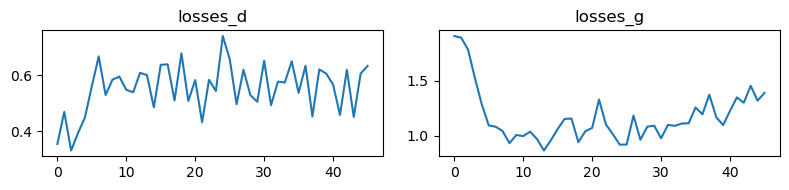

Epoch 46
Time for epoch:  23.14942693710327
Epoch 47
Time for epoch:  23.0497624874115
Epoch 48
Time for epoch:  22.652156352996826
Epoch 49
Time for epoch:  22.649645805358887
Epoch 50
Time for epoch:  22.609718084335327
loss_d=0.55897, loss_g=1.41318
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


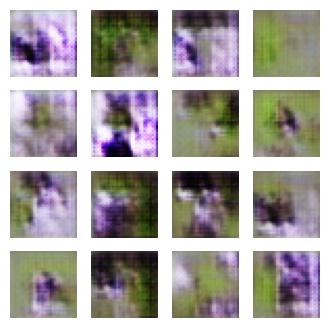

<Figure size 1600x1600 with 0 Axes>

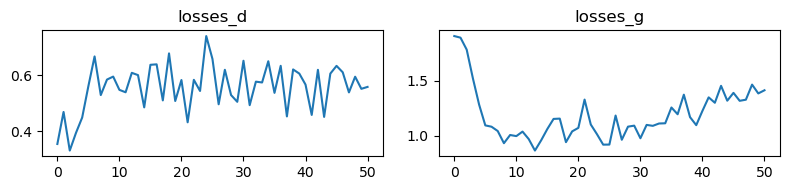

Epoch 51
Time for epoch:  23.226206064224243
Epoch 52
Time for epoch:  22.842767477035522
Epoch 53
Time for epoch:  24.3857684135437
Epoch 54
Time for epoch:  23.6618435382843
Epoch 55
Time for epoch:  23.28689980506897
loss_d=0.42671, loss_g=1.60624
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


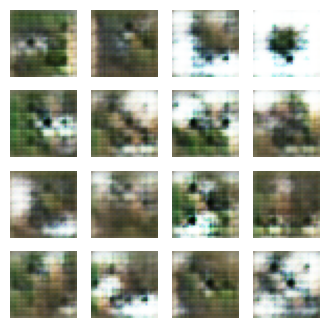

<Figure size 1600x1600 with 0 Axes>

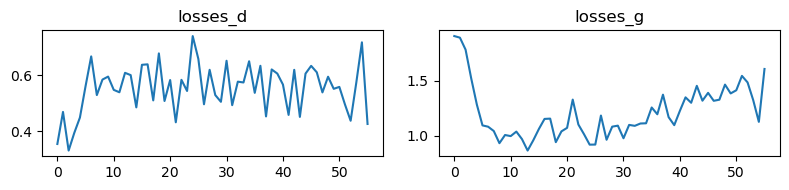

Epoch 56
Time for epoch:  23.292429447174072
Epoch 57
Time for epoch:  23.004321098327637
Epoch 58
Time for epoch:  22.648488998413086
Epoch 59
Time for epoch:  22.976519107818604
Epoch 60
Time for epoch:  22.658187866210938
loss_d=0.58822, loss_g=1.37405
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


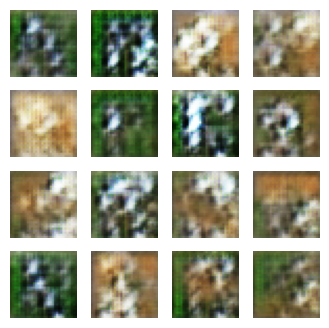

<Figure size 1600x1600 with 0 Axes>

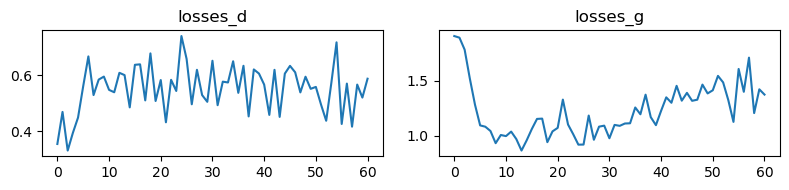

Epoch 61
Time for epoch:  23.137325286865234
Epoch 62
Time for epoch:  22.66764211654663
Epoch 63
Time for epoch:  22.719520807266235
Epoch 64
Time for epoch:  22.63192629814148
Epoch 65
Time for epoch:  22.57992696762085
loss_d=0.54491, loss_g=1.80667
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


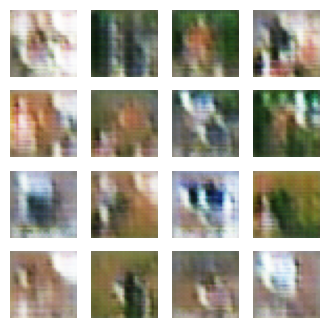

<Figure size 1600x1600 with 0 Axes>

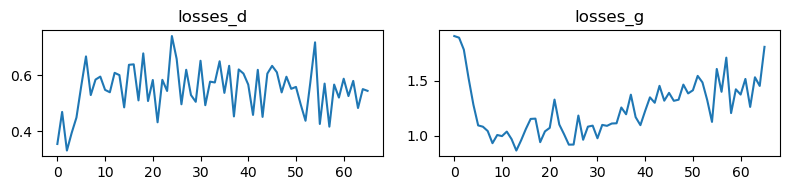

Epoch 66
Time for epoch:  22.736859798431396
Epoch 67
Time for epoch:  23.056476831436157
Epoch 68
Time for epoch:  22.741065740585327
Epoch 69
Time for epoch:  22.78085160255432
Epoch 70
Time for epoch:  23.157280921936035
loss_d=0.46694, loss_g=1.50648
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


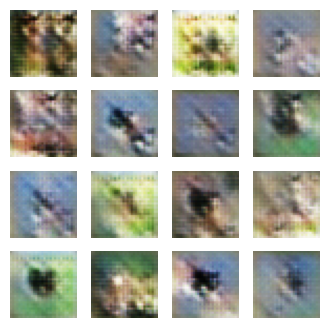

<Figure size 1600x1600 with 0 Axes>

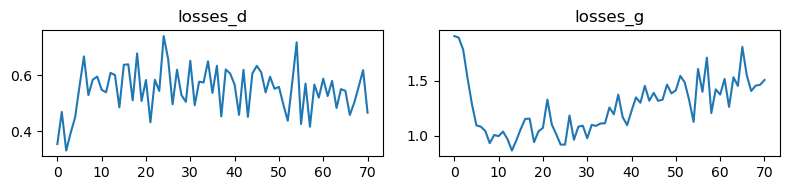

Epoch 71
Time for epoch:  23.602500438690186
Epoch 72
Time for epoch:  23.893330097198486
Epoch 73
Time for epoch:  22.84686589241028
Epoch 74
Time for epoch:  23.494693756103516
Epoch 75
Time for epoch:  23.010135173797607
loss_d=0.52110, loss_g=1.61859
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


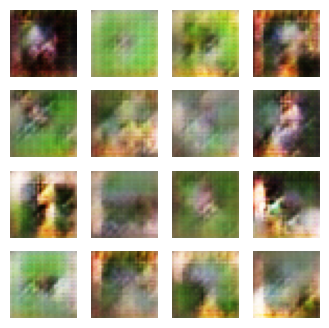

<Figure size 1600x1600 with 0 Axes>

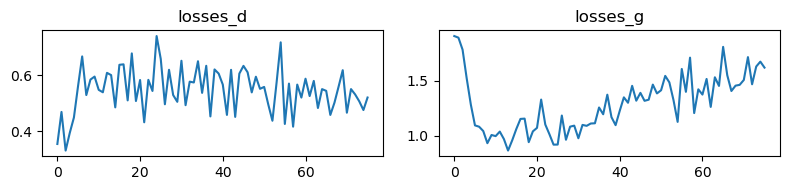

Epoch 76
Time for epoch:  22.92185354232788
Epoch 77
Time for epoch:  22.798393487930298
Epoch 78
Time for epoch:  23.33208417892456
Epoch 79
Time for epoch:  22.7534339427948
Epoch 80
Time for epoch:  22.757854223251343
loss_d=0.46334, loss_g=1.59347
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


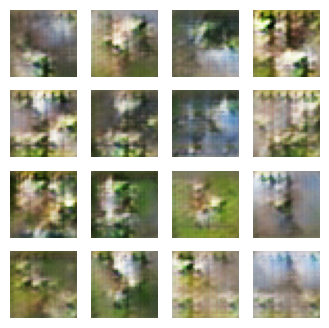

<Figure size 1600x1600 with 0 Axes>

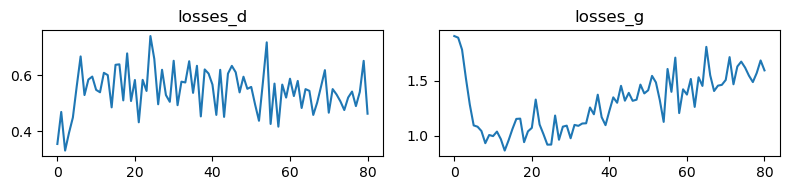

Epoch 81
Time for epoch:  23.062248706817627
Epoch 82
Time for epoch:  23.152863264083862
Epoch 83
Time for epoch:  22.985398530960083
Epoch 84
Time for epoch:  22.85258388519287
Epoch 85
Time for epoch:  22.828142166137695
loss_d=0.45627, loss_g=1.55805
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


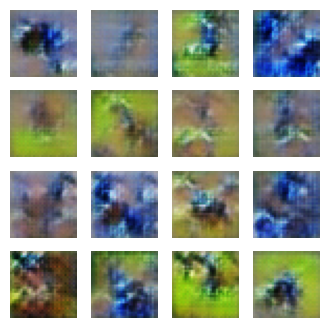

<Figure size 1600x1600 with 0 Axes>

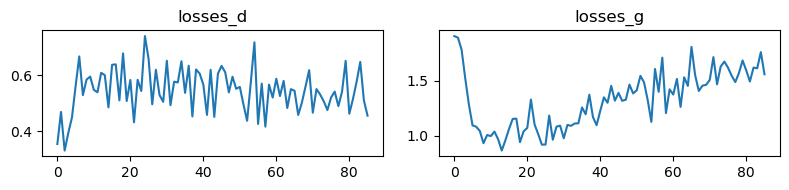

Epoch 86
Time for epoch:  22.93627405166626
Epoch 87
Time for epoch:  23.19204020500183
Epoch 88
Time for epoch:  24.51137948036194
Epoch 89
Time for epoch:  22.73399782180786
Epoch 90
Time for epoch:  22.721299648284912
loss_d=0.69326, loss_g=1.82765
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


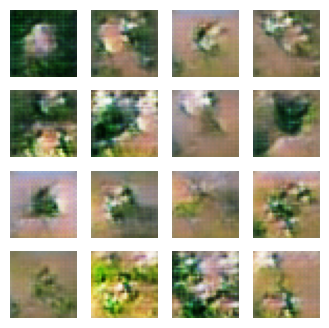

<Figure size 1600x1600 with 0 Axes>

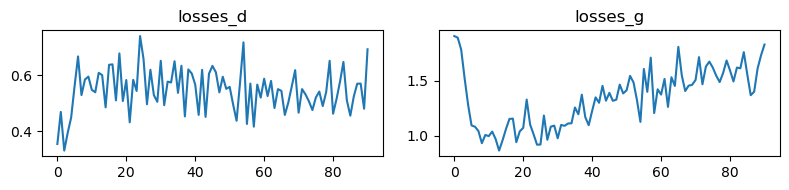

Epoch 91
Time for epoch:  22.522114515304565
Epoch 92
Time for epoch:  22.782965421676636
Epoch 93
Time for epoch:  23.280758142471313
Epoch 94
Time for epoch:  22.733181476593018
Epoch 95
Time for epoch:  22.601323127746582
loss_d=0.49177, loss_g=1.51239
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


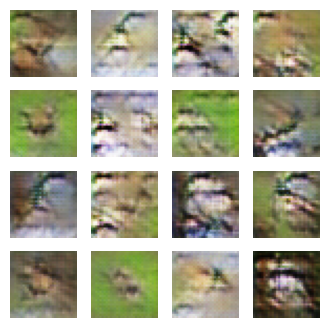

<Figure size 1600x1600 with 0 Axes>

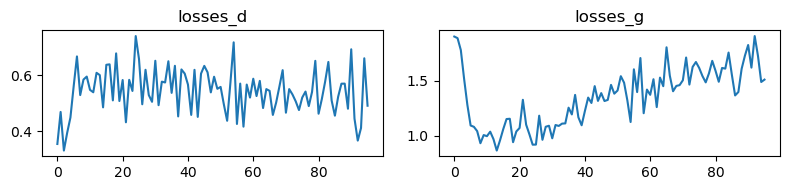

Epoch 96
Time for epoch:  23.0453200340271
Epoch 97
Time for epoch:  22.657098054885864
Epoch 98
Time for epoch:  23.08811616897583
Epoch 99
Time for epoch:  22.794960021972656
Epoch 100
Time for epoch:  22.82582402229309
loss_d=0.60395, loss_g=1.19641
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


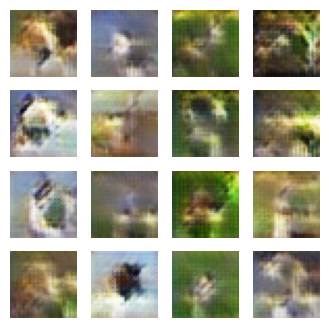

<Figure size 1600x1600 with 0 Axes>

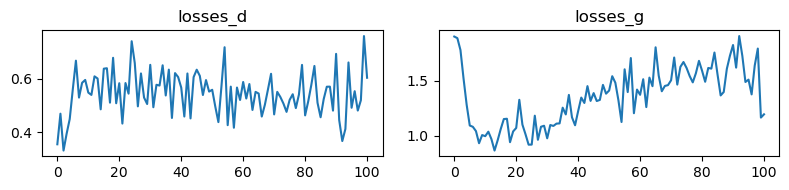

Epoch 101
Time for epoch:  22.659318208694458
Epoch 102
Time for epoch:  22.642223358154297
Epoch 103
Time for epoch:  22.863651037216187
Epoch 104
Time for epoch:  22.755305290222168
Epoch 105
Time for epoch:  22.660067796707153
loss_d=0.61071, loss_g=1.47939
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


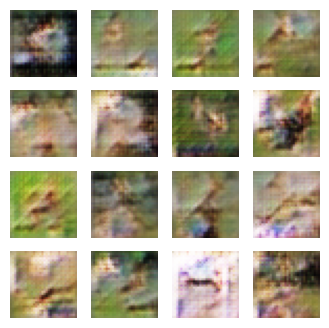

<Figure size 1600x1600 with 0 Axes>

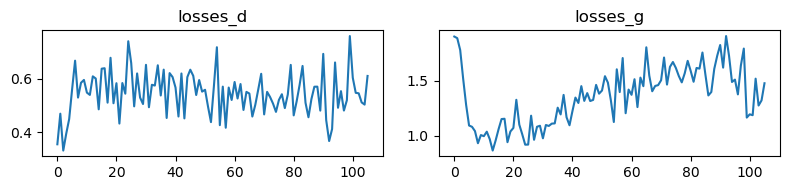

Epoch 106
Time for epoch:  22.61272406578064
Epoch 107
Time for epoch:  22.84428572654724
Epoch 108
Time for epoch:  22.722968578338623
Epoch 109
Time for epoch:  22.714223861694336
Epoch 110
Time for epoch:  22.580429792404175
loss_d=0.52328, loss_g=1.51363
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


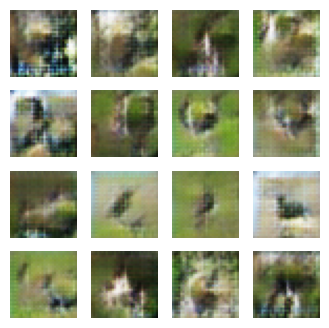

<Figure size 1600x1600 with 0 Axes>

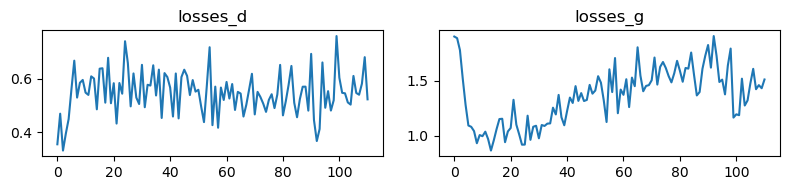

Epoch 111
Time for epoch:  22.852111339569092
Epoch 112
Time for epoch:  25.94231867790222
Epoch 113
Time for epoch:  24.09461522102356
Epoch 114
Time for epoch:  26.260546445846558
Epoch 115
Time for epoch:  25.148043632507324
loss_d=0.53884, loss_g=1.32971
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


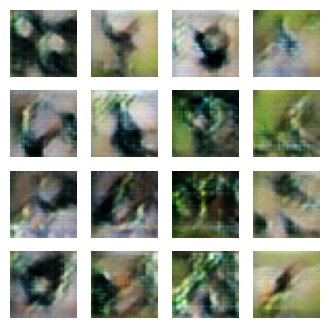

<Figure size 1600x1600 with 0 Axes>

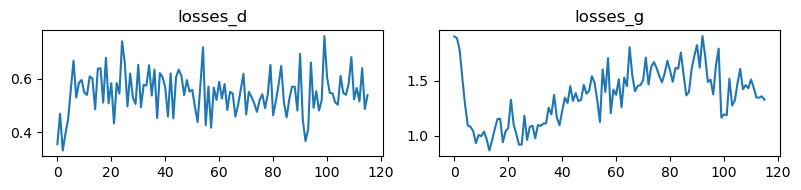

Epoch 116
Time for epoch:  25.127442598342896
Epoch 117
Time for epoch:  25.098015785217285
Epoch 118
Time for epoch:  24.704806566238403
Epoch 119
Time for epoch:  24.5379421710968
Epoch 120
Time for epoch:  24.89713406562805
loss_d=0.55388, loss_g=1.38680
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


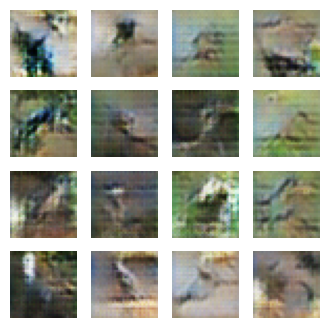

<Figure size 1600x1600 with 0 Axes>

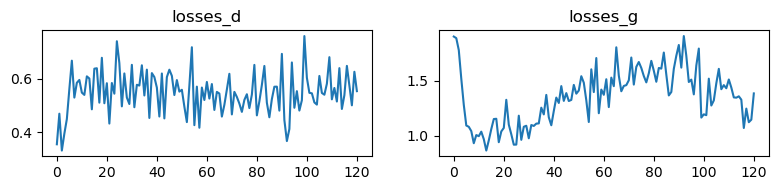

Epoch 121
Time for epoch:  25.027517795562744
Epoch 122
Time for epoch:  25.337097883224487
Epoch 123
Time for epoch:  25.882517099380493
Epoch 124
Time for epoch:  25.196473360061646
Epoch 125
Time for epoch:  24.9471652507782
loss_d=0.61982, loss_g=1.21616
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


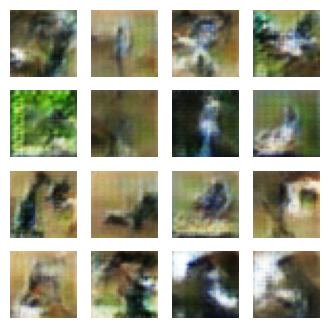

<Figure size 1600x1600 with 0 Axes>

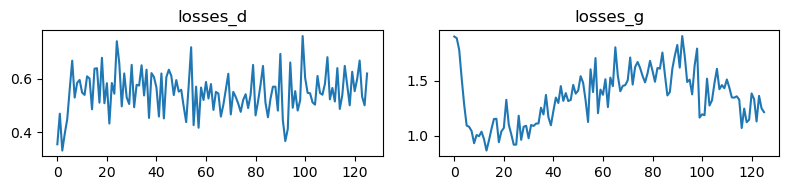

Epoch 126
Time for epoch:  25.371173858642578
Epoch 127
Time for epoch:  25.614261150360107
Epoch 128
Time for epoch:  25.152732610702515
Epoch 129
Time for epoch:  25.30957007408142
Epoch 130
Time for epoch:  25.29662775993347
loss_d=0.52092, loss_g=1.33214
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


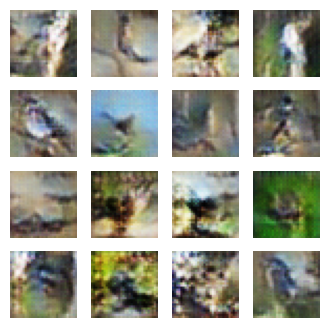

<Figure size 1600x1600 with 0 Axes>

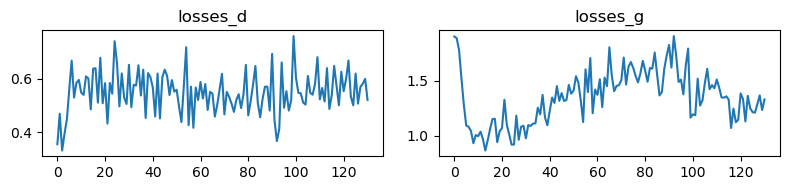

Epoch 131
Time for epoch:  24.983802556991577
Epoch 132
Time for epoch:  25.07090663909912
Epoch 133
Time for epoch:  25.600090742111206
Epoch 134
Time for epoch:  25.28768253326416
Epoch 135
Time for epoch:  25.145228385925293
loss_d=0.56745, loss_g=1.08499
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


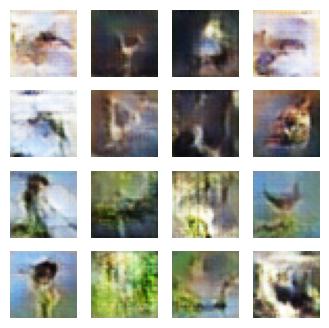

<Figure size 1600x1600 with 0 Axes>

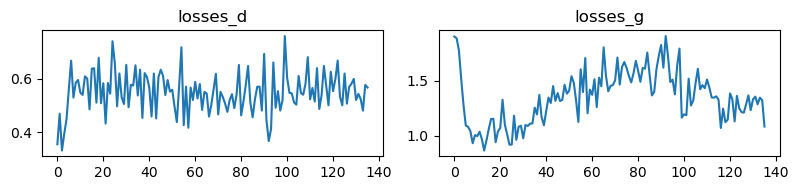

Epoch 136
Time for epoch:  25.13572096824646
Epoch 137
Time for epoch:  25.397435903549194
Epoch 138
Time for epoch:  24.833154916763306
Epoch 139
Time for epoch:  25.089092254638672
Epoch 140
Time for epoch:  25.80185079574585
loss_d=0.56857, loss_g=1.31487
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


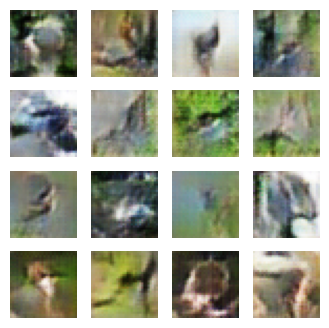

<Figure size 1600x1600 with 0 Axes>

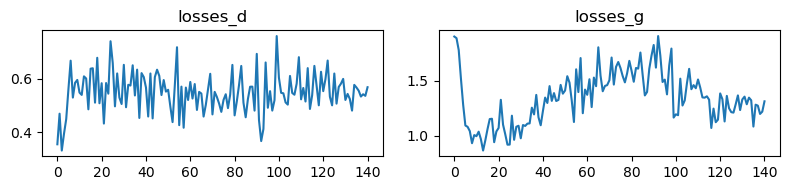

Epoch 141
Time for epoch:  24.875169277191162
Epoch 142
Time for epoch:  24.982343196868896
Epoch 143
Time for epoch:  25.571798086166382
Epoch 144
Time for epoch:  24.798404455184937
Epoch 145
Time for epoch:  25.269628524780273
loss_d=0.66022, loss_g=1.31642
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


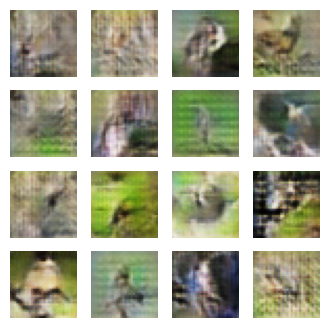

<Figure size 1600x1600 with 0 Axes>

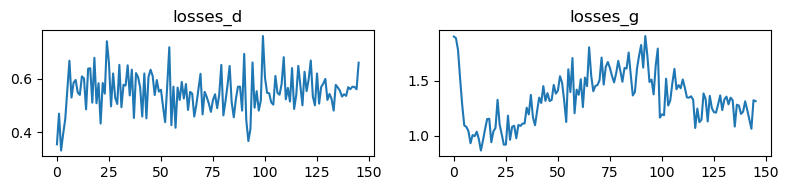

Epoch 146
Time for epoch:  25.91979694366455
Epoch 147
Time for epoch:  25.377071142196655
Epoch 148
Time for epoch:  25.341922521591187
Epoch 149
Time for epoch:  25.108980655670166


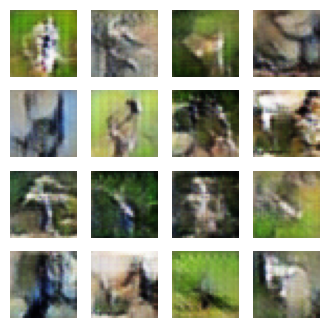

In [5]:
#Training Function
def train(z_dim=100, epochs=150,
          batch_size=16, epoch_per_checkpoint=5, n_checkpoint_images=36):

    #Load the CIFAR10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #Concatenate X_train and X_test for more data
    X_train = np.concatenate((X_train,X_test))
    y_train = np.concatenate((y_train,y_test))
    #Only grab birds
    index = np.where(y_train.reshape(-1) == 2)
    X_train = X_train[index]
    y_train = y_train[index]
    #Convert data to floats, Scale data to -1, 1
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = X_train/127.5 - 1.0
    
    
    #Get image shapes and values for reference
    image_shape = X_train[0].shape
    print("image shape {}, min val {}, max val {}".format(image_shape, X_train[0].min(), X_train[0].max()))
    #Plot real images for reference
    plot_images(X_train[:n_checkpoint_images], "real_images.png")


    #Get labels for computing the losses
    labels_real = np.ones(shape=(batch_size, 1)) 
    labels_fake = np.zeros(shape=(batch_size, 1))
    #Smooth labels to prevent mode collapse
    labels_real = smooth_positive_labels(labels_real)
    labels_fake = smooth_negative_labels(labels_fake)

    losses_d, losses_g = [], []

    
    # training loop
    for e in range(epochs):
        start = time.time()
        print("Epoch {}".format(e))
        for i in range(len(X_train) // batch_size):

            # update Discriminator weights
            D.trainable = True

            # Get real samples, train discriminator on them
            real_images = X_train[i*batch_size: (i+1)*batch_size]
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 real_images[j] = noisy(real_images[j])
            loss_d_real = D.train_on_batch(x=real_images, y=labels_real)[0]

            # Make fake samples, train discriminator on them
            z = generate_latent_points(z_dim, batch_size)
            fake_images = G.predict_on_batch(z)
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 fake_images[j] = noisy(fake_images[j])
            loss_d_fake = D.train_on_batch(x=fake_images, y=labels_fake)[0]

            # Compute Discriminator's loss
            loss_d = 0.5 * (loss_d_real + loss_d_fake)

#             # Train the generator while the discriminator is static
#             D.trainable = False
#             loss_g1 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
#             # Update Generator again (train it twice as much as the Discriminator)
#             loss_g2 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
            
#             # Compute Generator's loss
#             loss_g = 0.5 * (loss_g1 + loss_g2)
            # Train the generator while the discriminator is static
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=labels_real)[0]


        #Keep track of losses for plotting
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        
        end = time.time()
        print("Time for epoch:  " + str(end-start))

        
        #Plot losses and generated images every X epochs
        if (e % epoch_per_checkpoint) == 0:
            print("loss_d={:.5f}, loss_g={:.5f}".format(loss_d, loss_g))
            
            # fix a z vector for training evaluation
            z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
            
            fake_images = G.predict(z_fixed)
            print("\tPlotting images and losses")
            plot_images(fake_images, "fake_images_birds_e{}.png".format(e))
            plot_losses(losses_d, losses_g, "losses.png")
            
            #Show Images
            fake_images = (fake_images + 1) * 127.5
            fake_images = np.rint(fake_images)
            fake_images = fake_images.astype(int)

            fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)
            cnt=0
            for k in range(4):
                for l in range(4):
                    axs[k, l].imshow(fake_images[cnt,:,:])
                    axs[k, l].axis('off')
                    cnt+=1

            #Save Model every 10 epochs
#             if (e % 10) == 0 and e != 0:
#                 print('Saving Models')
#                 D.save('./DiscriminatorModel')
#                 D_of_G.save('./CombinedModel')
            
            
train()

In [6]:
# # #Print example images 
# n_checkpoint_images = 100
# z_dim = 100
# #z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
# z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
# fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
# #Convert fake images into actual values for plotting (ints between 0 and 255)
# fake_images = (fake_images + 1) * 127.5
# fake_images = np.rint(fake_images)
# fake_images = fake_images.astype(int)

# fig,axs = plt.subplots(10,10,figsize=(5,5),sharey=True,sharex=True)
# cnt=0
# for k in range(10):
#     for l in range(10):
#         axs[k, l].imshow(fake_images[cnt,:,:])
#         axs[k, l].axis('off')
#         cnt+=1

4/4 [==============================] - 0s 10ms/step


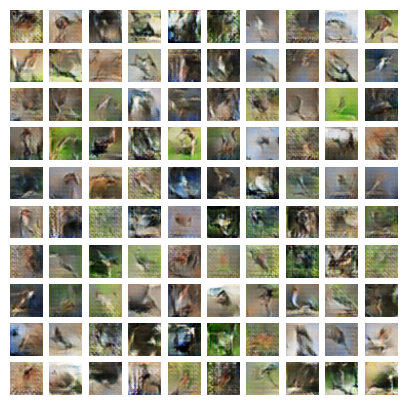

In [7]:
# #Print example images 
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(5,5),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1

4/4 [==============================] - 0s 9ms/step


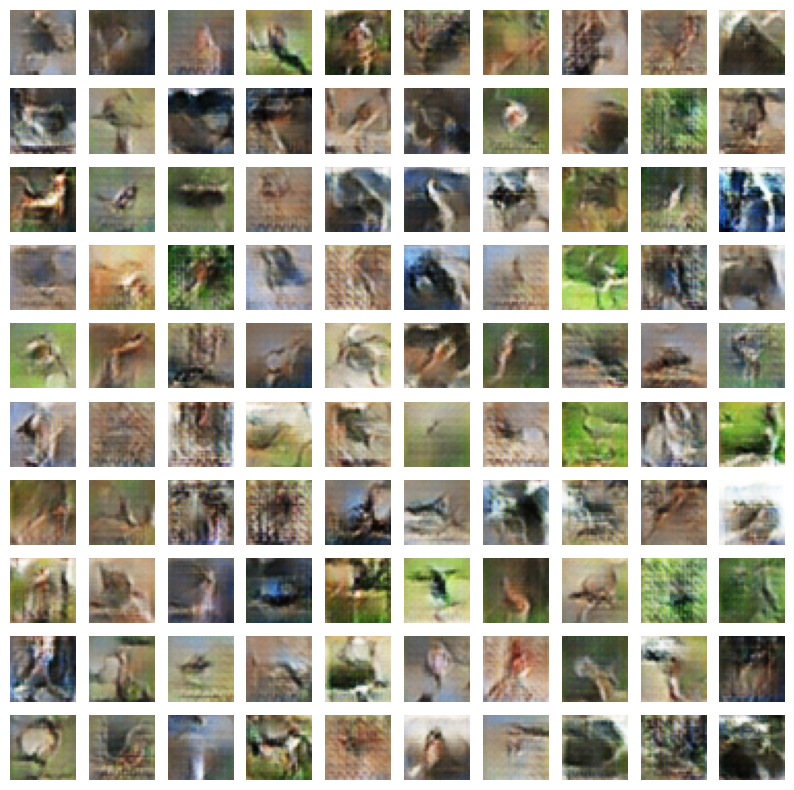

In [18]:
# #Print example images 
#Default Sets, 150 epochs
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(10,10),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1